# Finite Element Methods

Finite element methods discretize weak forms directly by choosing discrete subspaces for test and trial functions.  So an equation: find $u \in V$ such that
$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = 0, \quad \text{for all } v \in V $$
becomes: find $u_h \in V_h$ such that
$$ \int_{\Omega} \nabla v_h \cdot \kappa \cdot \nabla u_h = 0, \quad \text{for all } v_h \in V_h . $$
The integral is usually computed using quadrature which may or may not be exact.

To implement finite element methods, we need to define the discrete spaces $V_h$.  Usually these will be piecewise polynomial with some continuity between elements.  We'll start by working on a single element $(-1, 1)$ and will use a monomial basis for the moment, then provide a formal definition of finite elements and a more general construction.

## Quadrature

Finite element methods require numerical integration of weak forms.  This is usually done by **quadrature**

$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) . $$
There are many ways to choose the points $q_i$ and weights $w_i$.  For example, the trapezoid rule is a quadrature.

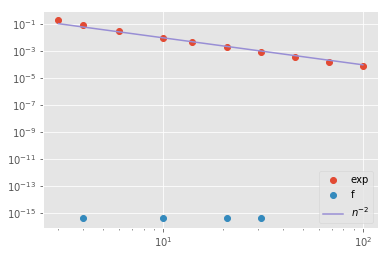

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def quad_trapezoid(n):
    q = numpy.linspace(-1, 1, n)
    w = 0*q + 2/(n-1)
    w[[0,-1]] /= 2
    return q, w

def plot_quad_accuracy(fs, quad):
    ns = numpy.logspace(.5, 2, 10, dtype=int)
    for f, F in fs:
        exact = F(1) - F(-1)
        def err(n):
            q, w = quad(n)
            return w.dot(f(q)) - exact
        errors = [numpy.abs(err(n)) for n in ns]
        pyplot.loglog(ns, errors, 'o', label=f.__name__)
    pyplot.loglog(ns, ns**(-2.), label='$n^{{-2}}$')
    pyplot.legend()

def poly(p):
    def f(x):
        return numpy.polyval(p, x)
    pint = numpy.polyint(p)
    def F(x):
        return numpy.polyval(pint, x)
    return f, F
    
plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2])],
                   quad_trapezoid)

### Gauss quadrature

Methods like the trapezoid rule are inefficient for integrating polynomials and related functions, in the sense that they need many points to reach desired accuracy tolerances.  Gauss quadrature is a spectrally accurate method that can exactly integrate polynomials of degree $2n-1$ using $n$ points.  To derive Gauss quadrature, we will need the Legendre polynomials $P_n(x)$, first discovered in the early 19th century as eigenfunctions (resonant modes) of the differential operator
$$ \frac{d}{d x} (1 - x^2) \frac{d P_n(x)}{dx} $$
on the interval $(-1, 1)$.
Legendre polynomials can also be derived by applying Gram-Schmidt orthogonalization to the monomials using the inner product
$$ \langle P_m, P_n \rangle = \int_{-1}^1 P_m(x) P_n(x) $$
and a normalization convention that $P_n(1) = 1$.
In practice, we will use the recursive definition
$$\begin{split}
P_0(x) &= 1 \\
P_1(x) &= x \\
(n+1) P_{n+1}(x) &= (2n+1) x P_n(x) - n P_{n-1}(x)
\end{split}$$

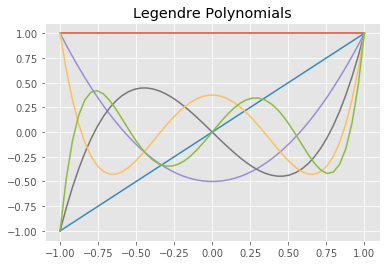

In [2]:
def vander_legendre(x, n=None):
    if n is None:
        n = len(x)
    P = numpy.ones((len(x), n))
    if n > 1:
        P[:,1] = x
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
    return P

x = numpy.linspace(-1, 1)
P = vander_legendre(x, 6)
pyplot.figure()
pyplot.plot(x, P)
pyplot.title('Legendre Polynomials');

Since the polynomials $P_n$ are orthogonal to $P_0(x) = 1$ in particular,
$$ \int_{-1}^1 P_n(x) = 0, \quad n=1,2,\dotsc $$
which means that we can integrate an arbitrary function by writing the Lagrange interpolating polynomial in the Legendre basis
$$ p_n(x) = \sum_{i=0}^n c_i P_i(x) $$
and integrating
$$ \int_{-1}^1 p_n(x) = 2 c_0 . $$

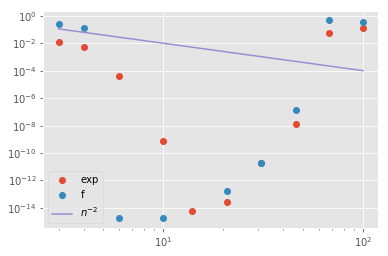

In [3]:
def quad_lin_legendre(n):
    q = numpy.linspace(-1, 1, n)
    P = vander_legendre(q)
    w = 2*numpy.linalg.solve(P.T, numpy.eye(n, 1)).flatten()
    return q, w

plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2,3,4,5])],
                   quad_lin_legendre)

This is quite accurate when using just a few points, but becomes unstable due to the [Runge phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).  We could control this by choosing `cosspace` points like we did for Chebyshev methods, but it is possible to do much better.  Suppose we write a polynomial on the interval $(-1,1)$ as

$$ p_{2n-1}(x) = P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

#### Derivatives of Legendre Polynomials

The derivatives of Legendre polynomials satisfy a recurrence,
$$ P_{n+1}'(x) = (2n+1) P_n(x) + P_{n-1}'(x) . $$

With the ability to compute $P_n(x)$ and $P_n'(x)$, we can use Newton's method to compute the roots.
It turns out that `cos(linspace(.5/(n-1), 1-.5/(n-1), n) * pi)` is a good initial guess.

3.357847e-02 [-0.8660254  -0.34202014  0.34202014  0.8660254 ]
5.193689e-04 [-0.86121415 -0.33998259  0.33998259  0.86121415]
1.346162e-07 [-0.86113633 -0.33998104  0.33998104  0.86113633]
9.106875e-15 [-0.86113631 -0.33998104  0.33998104  0.86113631]
|w1 - w2| = 3.063190e-15


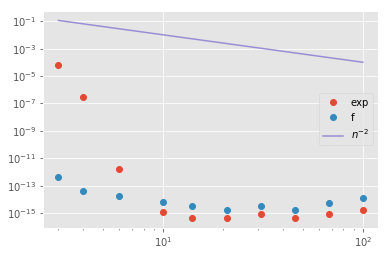

In [4]:
def vander_legendre_deriv(x, n=None):
    if n is None:
        n = len(x)
    P = numpy.ones((len(x), n))
    dP = numpy.zeros_like(P)
    if n > 1:
        P[:,1] = x
        dP[:,1] = 1
    for k in range(1,n-1):
        P[:,k+1] = ((2*k+1) * x * P[:,k] - k * P[:,k-1]) / (k + 1)
        dP[:,k+1] = (2*k+1) * P[:,k] + dP[:,k-1]
    return P, dP

def quad_gauss_legendre(n, verbose=False):
    q = numpy.cos(numpy.linspace(-1+.5/(n-1), -.5/(n-1), n) * numpy.pi)
    for i in range(20):
        P, dP = vander_legendre_deriv(q, n+1)
        Pn = P[:,-1]
        dPn = dP[:,-1]
        if verbose:
            print('{:10e} {}'.format(numpy.linalg.norm(Pn), q))
        if numpy.linalg.norm(Pn) < 1e-12:
            break
        q -= Pn / dPn
    w1 = 2*numpy.linalg.solve(P[:,:-1].T, numpy.eye(n, 1)).flatten()
    w2 = 2 / ((1-q**2)*dPn**2) # There is a closed form solution
    if verbose:
        print('|w1 - w2| = {:10e}'.format(numpy.linalg.norm(w1 - w2)))
    return q, w2

quad_gauss_legendre(4, verbose=True)
plot_quad_accuracy([(numpy.exp, numpy.exp),
                    poly([1,2,3,4,5])],
                   quad_gauss_legendre)

## Interpolation nodes

We will define the finite element solution $u_h \in V_h$ by the Lagrange interpolating polynomials on some set of nodes $x_i$.

cond 2.775548e+00


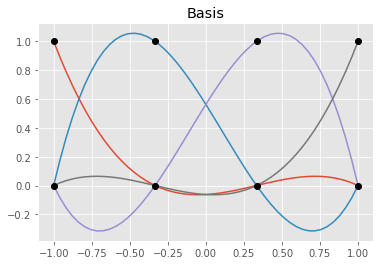

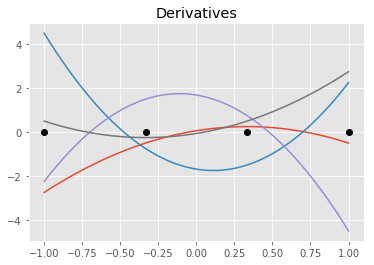

In [5]:
%run fdtools.py

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

x = numpy.linspace(-1, 1, 4)

def febasis(x, q):
    B = numpy.zeros((len(q), len(x)))
    D = numpy.empty_like(B)
    for i, qi in enumerate(q):
        c = fdstencil(qi, x, nderiv=1)
        B[i] = c[0]
        D[i] = c[1]
    return B, D

xx = numpy.linspace(-1, 1)
B, D = febasis(x, xx)
pyplot.plot(xx, B)
pyplot.plot(x, 0*x, 'ok')
pyplot.plot(x, 0*x+1, 'ok')
pyplot.title('Basis');
pyplot.figure()
pyplot.plot(xx, D)
pyplot.plot(x, 0*x, 'ok')
pyplot.title('Derivatives')
print('cond {:10e}'.format(numpy.linalg.cond(B)))

## Galerkin method

### $L^2$ projection

$L^2$ projection refers to the problem: find $u \in V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \text{for all } v \in V_h$$
and is an excellent first test problem because it does not require derivatives.  This projection should be exact if $f(x) \in V_h$.

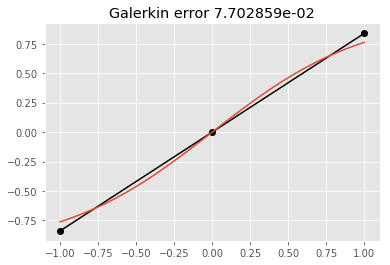

In [6]:
def L2_galerkin(n, f):
    x = cosspace(-1, 1, n)
    q, w = quad_gauss_legendre(n)
    B, D = febasis(x, q)
    rhs = B.T @ (w * f(q))
    A = B.T * w @ B
    u = numpy.linalg.solve(A, rhs)
    return x, u

def plot_galerkin(x, u, f):
    q = numpy.linspace(-1, 1)
    B, _ = febasis(x, q)
    pyplot.plot(x, u, 'ok')
    pyplot.plot(q, B@u, '-k')
    pyplot.plot(q, f(q))
    pyplot.title('Galerkin error {:8e}'.format(numpy.linalg.norm(B@u - f(q), numpy.inf)))

x, u = L2_galerkin(3, numpy.tanh)
plot_galerkin(x, u, numpy.tanh)

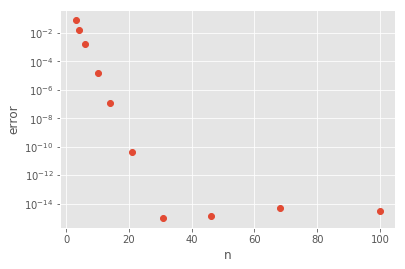

In [7]:
def L2_galerkin_convergence(f):
    ns = numpy.logspace(.5, 2, 10, dtype=int)
    def error(n):
        x, u = L2_galerkin(n, f)
        return numpy.linalg.norm(u - f(x), numpy.inf)
    errors = [error(n) for n in ns]
    pyplot.semilogy(ns, errors, 'o')
    pyplot.xlabel('n')
    pyplot.ylabel('error')
    
L2_galerkin_convergence(numpy.tanh)

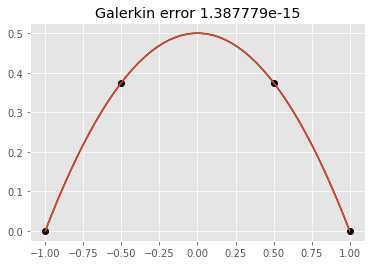

In [8]:
def laplace_galerkin(n, f):
    x = cosspace(-1, 1, n)
    q, w = quad_gauss_legendre(n)
    B, D = febasis(x, q)
    rhs = B.T @ (w * f(q))
    A = D.T * w @ D
    A[0] = 0
    A[0,0] = 1
    rhs[0] = 0
    A[-1] = 0
    A[-1,-1] = 1
    rhs[-1] = 0
    u = numpy.linalg.solve(A, rhs)
    return x, u

x, u = laplace_galerkin(4, lambda x:0*x+1)
plot_galerkin(x, u, lambda x:.5*(1 - x**2))